In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
#mpl.use('pdf')
import sys
sys.path.append("../")
import copy
from Plotting.generate_database import ResultsDatabaseGenerator
from common_packages.utilities import get_equivalent_classical_layer_size, get_num_parameters_per_quantum_layer
from Plotting.Plot import BasicPlot, MultiPlot
import pandas as pd
import seaborn as sns
colors =   ["#5dd448",
            "#bfa900",
            "#ec742f",
            "#e9496f",
            "#b04ca4",]
palette = sns.color_palette('pastel')
colors = palette.as_hex()

sns.set_style('ticks')

#colors = ["#332288", "#88CCEE", "#44AA99", "#117733", "#999933", "#DDCC77", "#CC6677", "#882255", "#AA4499"]
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=colors)
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.size"] = 10
plt.rcParams["axes.linewidth"] = 0.5

import tensorflow as tf
tf.compat.v1.enable_eager_execution()

from quantum_kerr import Net
from data import generate_synthetic_dataset_easy


%load_ext autoreload
%autoreload 2

2023-11-13 09:44:27.102107: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-11-13 09:44:27.102123: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
model = Net(quantum_preparation_layer=True, max_initial_weight=0.2109)
train_data, test_data = generate_synthetic_dataset_easy(num_datapoints=1000, n_features=8, n_classes=4)

x = train_data[0][0:2]
print(x.shape)
model(x)
print(model.quantum_layer.traces)

2023-11-13 09:44:31.482947: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-13 09:44:31.483154: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-11-13 09:44:31.483227: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2023-11-13 09:44:31.483309: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2023-11-13 09:44:31.483375: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

(2, 8)
ListWrapper([0.9999365210533142, 0.9999300241470337])


In [3]:
kerr_cutoff_path = './Experiment_cutoff_hybrid_with_trace_kerr2/'

def generate_database(ex_path):
    dbGen = ResultsDatabaseGenerator()
    dbGen.initialize_from_folder(ex_path)
    data = dbGen.data
    config = data[1]['config']
    config.pop('__doc__', None)
    #config.pop('iteration', None)
    df = pd.DataFrame(columns=config.keys())
    df['iteration'] = np.nan
    # df['epoch'] = np.nan
    # df['acc'] = np.nan
    # df['val_acc'] = np.nan
    # df['loss'] = np.nan
    # df['val_loss'] = np.nan
    # df['traces_average'] = np.nan
    # df['trace_sum'] = np.nan
    # df['traces_std'] = np.nan
    for key in data[1]['metrics'].keys():
        df[key] = np.nan
    #df['trace_sum'] = np.nan
    for i in data.keys():
        config = data[i]['config']
        config.pop('__doc__', None)
        try:
            config['iteration']
        except KeyError:
            config['iteration'] = 1
        if config['iteration'] != -1:
            metrics = data[i]['metrics']
            temp_dict = {}
            for key in metrics.keys():
                temp_dict[key] = metrics[key]
            for key in config.keys():
                temp_dict[key] = config[key]
            df.loc[i] = temp_dict
            # print(metrics.keys())
            # acc, epoch, loss, trace_sum, traces_average, traces_std, traces_sum, val_acc, val_loss = metrics.values()
            # if acc[-1] > 0.0:
            #     acc = np.array(acc)
            #     loss = np.array(loss)
            #     val_acc = np.array(val_acc)
            #     val_loss = np.array(val_loss)
            #     df.loc[i] = [*config.values(), epoch, acc, val_acc, loss, val_loss, traces_average, traces_sum, traces_std]
    return df

df = generate_database(kerr_cutoff_path)
#df.drop(columns=['trace_sum'], inplace=True)
display(df.head())
display(df.describe())

,iteration,quantum_preparation_layer,regularizer_string,scale_max,accuracy,epoch,loss,traces_average,traces_std,val_accuracy,val_loss
5,0,True,L1=0.1,1,"[0.20714285969734192, 0.33714285492897034, 0.5...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[1.415027141571045, 1.3563416004180908, 1.3038...","[0.9996660425662994, 0.9997381356358528, 0.999...","[8.723621605623137e-05, 5.417653306052065e-05,...","[0.27666667103767395, 0.5233333110809326, 0.56...","[1.3699092864990234, 1.3170613050460815, 1.261..."
1,0,False,None,1,"[0.2742857038974762, 0.35857143998146057, 0.49...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[1.3900833129882812, 1.3220328092575073, 1.253...","[0.6957691508829593, 0.6835951823592186, 0.800...","[0.11884280396629712, 0.11180688362329232, 0.1...","[0.2433333396911621, 0.4566666781902313, 0.493...","[1.34632408618927, 1.290333867073059, 1.213941..."
3,0,False,None,3,"[0.3514285683631897, 0.5128571391105652, 0.495...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[1.3669246435165405, 1.2976568937301636, 1.215...","[0.5963300684094429, 0.6856663578748703, 0.787...","[0.12089624702713053, 0.11753818944817697, 0.0...","[0.5233333110809326, 0.49666666984558105, 0.55...","[1.3227735757827759, 1.2445944547653198, 1.140..."
6,0,True,L2=0.1,1,"[0.24285714328289032, 0.3514285683631897, 0.51...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[1.3754085302352905, 1.3380545377731323, 1.298...","[0.9996554917693138, 0.9996723893284798, 0.999...","[9.241762065478376e-05, 7.41630698839578e-05, ...","[0.30000001192092896, 0.5266666412353516, 0.56...","[1.3432425260543823, 1.3074520826339722, 1.261..."
2,0,False,None,9,"[0.4714285731315613, 0.4714285731315613, 0.442...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[1.3783061504364014, 1.364724040031433, 1.3412...","[0.07826030200719833, 0.11011799352988601, 0.1...","[0.047700906203332685, 0.0693445121454514, 0.0...","[0.47333332896232605, 0.5199999809265137, 0.43...","[1.3709863424301147, 1.353156566619873, 1.3174..."


,iteration,scale_max
count,7.0,7.000000
mean,0.0,3.142857
std,0.0,3.184785
min,0.0,1.000000
25%,0.0,1.000000
50%,0.0,1.000000
75%,0.0,4.500000
max,0.0,9.000000


In [14]:
reg_strings = df['regularizer_string'].unique()
scale_max = df['scale_max'].unique()
quantum_preperation = df['quantum_preparation_layer'].unique()

axs_dict = dict(zip(reg_strings, axs))
axs_dict = {k: dict(zip(scale_max, v)) for k, v in axs_dict.items()}

cols = ['accuracy', 'val_accuracy', 'loss', 'val_loss', 'traces_average', 'traces_std', 'epoch']

df_exp = df.explode(column=cols)
df_exp[cols] = df_exp[cols].apply(pd.to_numeric, errors='coerce')
df_exp.reset_index(inplace=True)
df_exp.pop('index')
display(df_exp.head())



,iteration,quantum_preparation_layer,regularizer_string,scale_max,accuracy,epoch,loss,traces_average,traces_std,val_accuracy,val_loss
0,0,True,L1=0.1,1,0.207143,0,1.415027,0.999666,0.000087,0.276667,1.369909
1,0,True,L1=0.1,1,0.337143,1,1.356342,0.999738,0.000054,0.523333,1.317061
2,0,True,L1=0.1,1,0.515714,2,1.303889,0.999671,0.000072,0.560000,1.261781
3,0,True,L1=0.1,1,0.474286,3,1.248625,0.999486,0.000103,0.500000,1.198485
4,0,True,L1=0.1,1,0.494286,4,1.183915,0.999259,0.000125,0.563333,1.134804


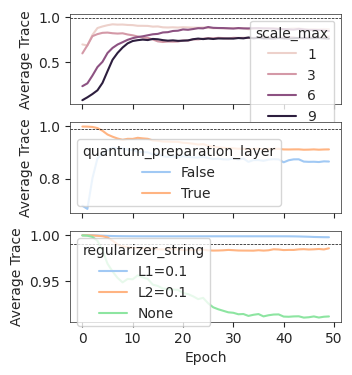

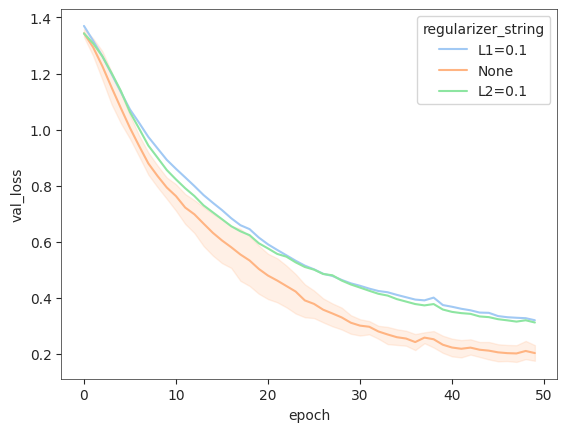

In [34]:
fig, ax = plt.subplots(3, 1, figsize=(3.5, 4), sharex=True)
sns.lineplot(x='epoch', y='traces_average', hue='quantum_preparation_layer',
             data=df_exp[(df_exp['scale_max']==1) & (df_exp['regularizer_string']=='None')], ax=ax[1])
ax[1].set_ylabel('Average Trace')
ax[1].axhline(y=0.99, linestyle='--', color='black', linewidth=0.5)
sns.lineplot(x='epoch', y='traces_average', hue='scale_max',
             data=df_exp[(df_exp['quantum_preparation_layer']==False) & (df_exp['regularizer_string']=='None')], ax=ax[0])
ax[0].axhline(y=0.99, linestyle='--', color='black', linewidth=0.5)
ax[0].set_ylabel('Average Trace')
sns.lineplot(x='epoch', y='traces_average', hue='regularizer_string',
             data=df_exp[(df_exp['quantum_preparation_layer']==True) & (df_exp['scale_max']==1)], ax=ax[2])
ax[2].axhline(y=0.99, linestyle='--', color='black', linewidth=0.5)
ax[2].set_ylabel('Average Trace')
ax[2].set_xlabel('Epoch')
plt.show()


sns.lineplot(x='epoch', y='val_loss', hue='regularizer_string',
             data=df_exp)
plt.show()

In [4]:

fig, axs = plt.subplots(len(reg_strings),len(scale_max), figsize=(10,10), sharex=True, sharey=True)
color_dict = dict(zip(quantum_preperation, colors))

for k1, v1 in axs_dict.items():
    for k2, v2 in v1.items():
        df_temp = df_exp[(df_exp['regularizer_string'] == k1) & (df_exp['scale_max'] == k2)]
        sns.lineplot(x='epoch', y='traces_average', hue='quantum_preparation_layer', data=df_temp, ax=v2, legend=False, hue_order=quantum_preperation)
        for qp in quantum_preperation:
            df_temp_qp = df_temp[df_temp['quantum_preparation_layer'] == qp]
            v2.fill_between(df_temp_qp['epoch'].values, 
                            df_temp_qp['traces_average'].values - df_temp_qp['traces_std'].values, 
                            df_temp_qp['traces_average'].values + df_temp_qp['traces_std'].values, color=color_dict[qp],
                            alpha=0.2)
        v2.axhline(y=0.99, color='k', linestyle='--')
        v2.set_title(f'{k1}, {k2}')

plt.plot([], [], color=color_dict[True], label='Quantum preparation layer')
plt.plot([], [], color=color_dict[False], label='No quantum preparation layer')
fig.legend()

plt.show()

,iteration,quantum_preparation_layer,regularizer_string,scale_max,accuracy,epoch,loss,traces_average,traces_std,val_accuracy,val_loss
0,0,True,L1=0.1,1,0.207143,0,1.415027,0.999666,0.000087,0.276667,1.369909
1,0,True,L1=0.1,1,0.337143,1,1.356342,0.999738,0.000054,0.523333,1.317061
2,0,True,L1=0.1,1,0.515714,2,1.303889,0.999671,0.000072,0.560000,1.261781
3,0,True,L1=0.1,1,0.474286,3,1.248625,0.999486,0.000103,0.500000,1.198485
4,0,True,L1=0.1,1,0.494286,4,1.183915,0.999259,0.000125,0.563333,1.134804


TypeError: 'NoneType' object is not iterable